# Learn a Regular Network States
khordad 1404

In [1]:
# import
import numpy as np
import os
import networkx as nx
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
from torch.nn import Linear
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Preparation data

In [2]:

# Skip the first line (header)
labels_data = np.loadtxt("./inputs/lables.txt", skiprows=1)   #row1= sample & q     # shape: (num_samples, 2:columns)

trial_numbers = labels_data[:, 0].astype(int)       # Sample indices
y = labels_data[:, 1]                               # Corresponding labels

print("Sample indices: ",trial_numbers,"\n")
print("Corresponding labels: ",y)

Sample indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] 

Corresponding labels:  [ 1. -1. -2.  0. -2.  1.  0.  0. -2. -1.  1.  0.  2.  2.  0.  0.  3.  0.
  3.  0.  1.  0.  0. -1.  0.  0.  0.  0. -3. -1.  1. -1. -1. -1. -2.  0.
  2. -1.  1. -1. -1.  0.  0.]


In [3]:
# Initialize a list to collect each sample
X_list = []

for trial in trial_numbers:
    filename = f"./inputs/I=InitialPhases/S_{trial}.txt"
    if os.path.exists(filename):
        x_i = np.loadtxt(filename)  # shape: (T,), one column per sample
        X_list.append(x_i)
    else:
        print(f"Warning: File {filename} not found.")


In [ ]:
# Convert to a 2D NumPy array (num_samples, sequence_length)
X = np.stack(X_list)

# Now, X and y are ready for use
print("X shape:", X.shape)  # e.g., (200, 1000)
print("y shape:", y.shape)  # e.g., (200,)


X shape: (43, 100)
y shape: (43,)


### Preproccesing

In [6]:
# === 1. Convert numpy arrays to GNN Data objects ===

def build_dataset(X, y, edge_index):
    data_list = []
    for i in range(len(X)):
        theta = X[i]                                                            # shape: (N_nodes,) # Get the initial phases for sample i
        sin_cos_features = np.stack([np.sin(theta), np.cos(theta)], axis=1)     # shape: (N_nodes, 2) # Convert the phases to 2D features
        x = torch.tensor(sin_cos_features, dtype=torch.float)                   # Convert node features to a PyTorch tensor
        y_val = torch.tensor(y[i], dtype=torch.long)                            # Convert the label (winding number class) to a PyTorch tensor   #regression:dtype=torch.float
        
        # Each object contains the node features (x), the graph structure (edge_index), and the graph label (y)
        data = Data(x=x, edge_index=edge_index, y=y_val)                        # Create a PyTorch Geometric Data object
        data_list.append(data)                                                  # Add this graph sample to the dataset list
    return data_list                                                            # Return the full dataset as a list of graph data objects

### Learning procces

In [7]:
# Define a Graph Convolutional Network (GCN) for graph-level classification

class GCNClassifier(torch.nn.Module):
    def __init__(self, node_feat_dim=2, hidden_dim=64, num_classes=5):    # node_feat_dim = sin+cos = 2 # <-- adjust num_classes
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(node_feat_dim, hidden_dim)                   # First GCN layer: transforms input node features to hidden_dim
        self.conv2 = GCNConv(hidden_dim, hidden_dim)                      # Second GCN layer: keeps the hidden size the same

        self.lin1 = Linear(hidden_dim, 64)                                # First fully connected (linear) layer: maps graph embedding to intermediate hidden size

        self.lin2 = Linear(64, num_classes)                               # Second linear layer: maps to output logits for each class  # output = class scores (logits)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))                             # First GCN + ReLU activation
        x = F.relu(self.conv2(x, edge_index))                             # Second GCN + ReLU activation
        x = global_mean_pool(x, batch)                                    # Global pooling: aggregates node features into graph-level embedding
        x = F.relu(self.lin1(x))                                          # Pass through first linear layer + ReLU
        x = self.lin2(x)                                                  # Final linear layer to get logits (raw scores) for classification
        return x                                                          # logits are returned; CrossEntropyLoss (not softmax)

In [ ]:
# === Example training loop ===

# Function to train the model for one epoch
def train(model, loader, optimizer, loss_fn):
    model.train()                                                   # Set model to training mode (enables dropout, etc.)
    total_loss = 0                                                  # Accumulator for total loss across all batches
    for data in loader:                                             # Iterate over mini-batches from the DataLoader
        optimizer.zero_grad()                                       # Clear previous gradients
        out = model(data.x, data.edge_index, data.batch)            # Forward pass through the GNN
        loss = loss_fn(out, data.y)                                 # Compute the classification loss
        loss.backward()                                             # Backpropagation to compute gradients
        optimizer.step()                                            # Update model parameters
        total_loss += loss.item()                                   # Accumulate loss
    return total_loss / len(loader)                                 # Return average loss across all batches

# Function to evaluate the model on validation/test data
def test(model, loader):
    model.eval()                                                    # Set model to evaluation mode (disables dropout, etc.)
    correct = 0                                                     # Counter for correct predictions
    total = 0                                                       # Total number of samples
    with torch.no_grad():                                           # No need to track gradients during evaluation
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)        # Forward pass
            pred = out.argmax(dim=1)                                # Get predicted class with highest logit
            correct += (pred == data.y).sum().item()                # Count correct predictions
            total += data.y.size(0)                                 # Count total samples
    acc = correct / total                                           # Compute overall accuracy
    return acc

In [15]:
# === Setup and run ===

def run_gnn_classifier(X, y, adjacency_matrix, num_classes, log_path="./results/training_log.txt"):
    edge_index = dense_to_sparse(torch.tensor(adjacency_matrix, dtype=torch.float))[0]      # Convert adjacency matrix to PyTorch Geometric's edge_index format
    dataset = build_dataset(X, y, edge_index)                            # Build a list of Data objects from initial phase data and labels
    # Split into train/test sets
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)  # 80% train, 20% test
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)   # DataLoader for training set
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)    # DataLoader for test set
    model = GCNClassifier(num_classes=num_classes)                       # Initialize the GCN model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)           # Adam optimizer
    loss_fn = torch.nn.CrossEntropyLoss()                                # Cross-entropy loss for classification

    train_losses, test_accuracies = [], []                               # Lists to record loss and accuracy values for each epoch
    os.makedirs("./results", exist_ok=True)
    # Training loop
    with open(log_path, "w") as f:
        f.write("Epoch\tLoss\tAccuracy\n")
        for epoch in range(50):
            loss = train(model, train_loader, optimizer, loss_fn)         # Train for one epoch
            acc = test(model, test_loader)                                # Evaluate on test set
            train_losses.append(loss)                                     # Store training loss
            test_accuracies.append(acc)                                   # Store test accuracy
            #print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
            f.write(f"{epoch+1}\t{loss:.4f}\t{acc:.4f}\n")

    # Plot loss and accuracy across epochs
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(train_losses, label='Train Loss')                          # Plot training loss
    ax[0].set_title("Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[1].plot(test_accuracies, label='Test Accuracy', color='green')     # Plot test accuracy
    ax[1].set_title("Test Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig("./results/loss_acc.jpg", dpi=100)
    plt.show()
    return model, test_loader                                             # Return trained model and test_loader for further evaluation


In [ ]:
# === Evaluation function ===
def evaluate_model(model, test_loader, Q_vals):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Get unique classes that actually appear in the test set
    unique_labels = sorted(np.unique(all_labels))
    unique_preds = sorted(np.unique(all_preds))
    all_classes = sorted(np.unique(np.concatenate([all_labels, all_preds])))
    print(f"Unique labels in test set: {unique_labels}")
    print(f"Unique predictions: {unique_preds}")
    print(f"All classes: {all_classes}")
    
    target_names_filtered = [f"Q={Q_vals[i]}" for i in all_classes]             # Create target names only for classes that appear

    # Confusion matrix - use only the classes that appear
    cm = confusion_matrix(all_labels, all_preds, labels=all_classes)
    Q_vals_filtered = [Q_vals[i] for i in all_classes]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Q_vals_filtered, yticklabels=Q_vals_filtered)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    os.makedirs("./results", exist_ok=True)
    plt.savefig("./results/Confusion_Matrix.jpg", dpi=100)
    plt.show()
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, labels=all_classes, target_names=target_names_filtered))

### Run GNN

Unique Q values: [-3. -2. -1.  0.  1.  2.  3.]
Number of classes: 7


c:\Users\N.J.M\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


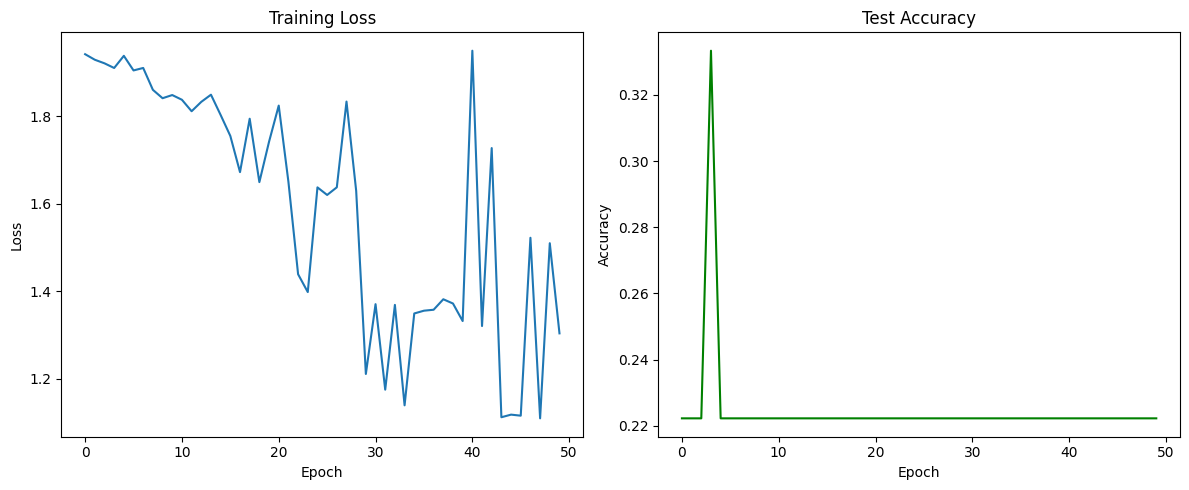

In [22]:
# === Create the graph topology ===
G = nx.watts_strogatz_graph(100, k=4, p=0.0)                    # ring lattice
A = nx.adjacency_matrix(G).todense()                            # Convert the graph to a dense adj matrix

# === Prepare classification labels ===                         # Suppose Q values are discrete (e.g., Q ∈ {-2, -1, 0, 1, 2})
Q_vals = np.unique(y)                                           # find all unique Q values (detects classes from your data)
Q_to_class = {q: i for i, q in enumerate(Q_vals)}               # Create a mapping: Q value → class index (e.g., -2 → 0, -1 → 1, ..., 2 → 4)
y_class = np.array([Q_to_class[q] for q in y])                  # Convert all Q values in `y` to class indices using the mapping
num_classes = len(Q_vals)                                       # Number of unique classes
print(f"Unique Q values: {Q_vals}")
print(f"Number of classes: {num_classes}")

# === Train the GNN classifier ===
model, test_loader = run_gnn_classifier(X, y_class, adjacency_matrix=A, num_classes=num_classes)

Unique labels in test set: [1, 2, 3, 5]
Unique predictions: [3]
All classes: [1, 2, 3, 5]


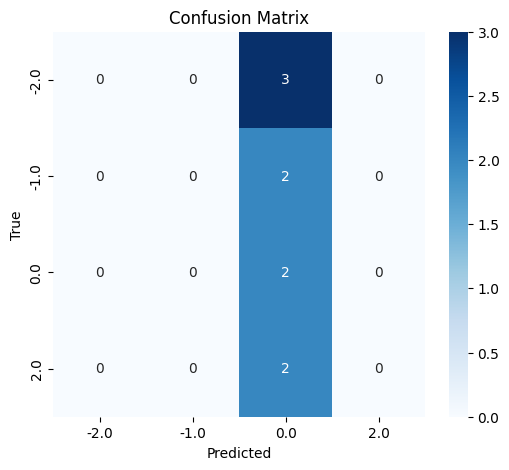

Classification Report:
              precision    recall  f1-score   support

      Q=-2.0       0.00      0.00      0.00         3
      Q=-1.0       0.00      0.00      0.00         2
       Q=0.0       0.22      1.00      0.36         2
       Q=2.0       0.00      0.00      0.00         2

    accuracy                           0.22         9
   macro avg       0.06      0.25      0.09         9
weighted avg       0.05      0.22      0.08         9



c:\Users\N.J.M\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\N.J.M\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\N.J.M\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [23]:
evaluate_model(model, test_loader, Q_vals)